[10:14:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


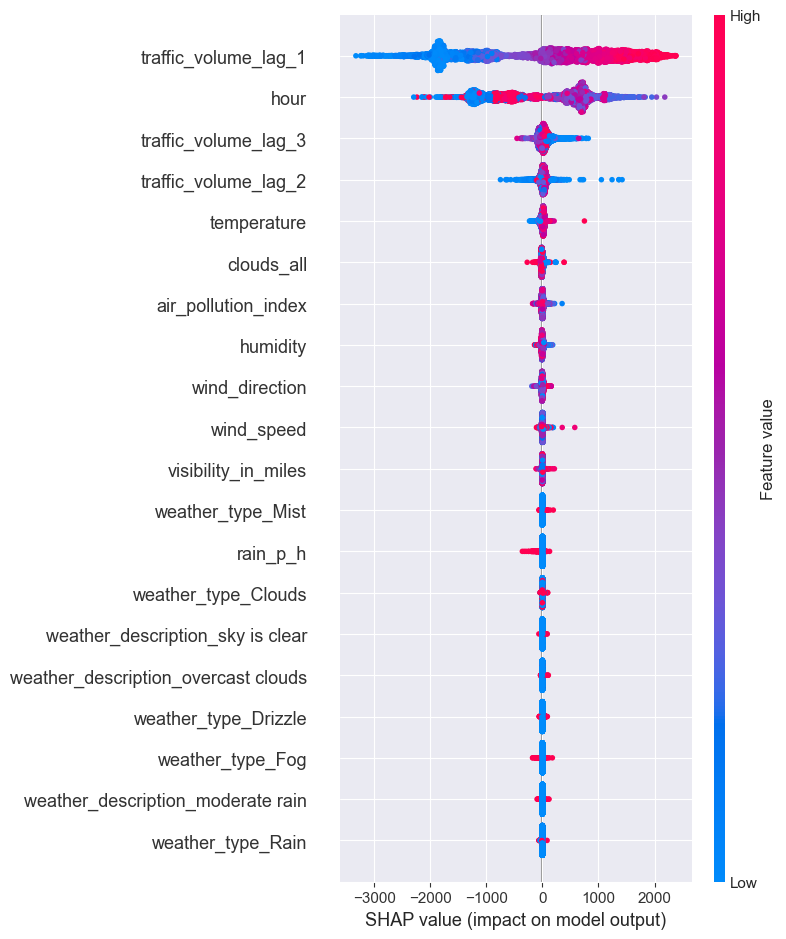

In [1]:
# Importing the required libraries
import shap
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Load dataset
df = pd.read_csv('Train.csv')

# Preprocessing as required by the given script
# Convert 'date_time' to datetime and set as index
df['date_time'] = pd.to_datetime(df['date_time'])
df = df.set_index('date_time')

# Convert 'is_holiday' to binary
df['is_holiday'] = df['is_holiday'].apply(lambda x: 0 if x == 'None' else 1)

# Extract hour from 'date_time'
df['hour'] = df.index.hour

# One-hot encode categorical features
df = pd.get_dummies(df, columns=['weather_type', 'weather_description'], drop_first=True)

# Create lag features
for i in range(1, 4):
    df[f'traffic_volume_lag_{i}'] = df['traffic_volume'].shift(i)

# Drop rows with NaN values
df.dropna(inplace=True)

# Define feature and target variables
X = df.drop(['traffic_volume'], axis=1)
y = df['traffic_volume']

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize XGBoost model
model = xgb.XGBRegressor()
model.fit(X_train_scaled, y_train)

# Explain the model's predictions using SHAP
explainer = shap.Explainer(model)

# After scaling, convert the NumPy array back to a DataFrame with column names
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

# Now when you create SHAP values, it should retain the feature names
shap_values = explainer.shap_values(X_test_scaled)

# Generate SHAP summary plot
shap.summary_plot(shap_values, X_test_scaled)


In [2]:
# Shape of the training data
print("Training data shape:", X_train_scaled.shape)

# Shape of the testing data
print("Testing data shape:", X_test_scaled.shape)


Training data shape: (26997, 62)
Testing data shape: (6750, 62)


In [7]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from lime.lime_tabular import LimeTabularExplainer

# Create a LIME explainer
explainer = lime_tabular.LimeTabularExplainer(X_train_scaled,
                                              mode='regression',
                                              feature_names=X.columns,
                                              discretize_continuous=False)

# Explain the model's predictions using LIME for a single instance
i = 0  # Choose the instance to explain
explanation = explainer.explain_instance(X_test_scaled[i], model.predict, num_features=len(X.columns))

# Plot LIME explanation with clearer feature names
fig, ax = explanation.as_pyplot_figure(label=1)
ax[0].set_yticklabels(X.columns, rotation=45, ha="right", fontsize=8)
plt.tight_layout()
plt.show()

KeyError: 0